## Set-up environment

In [1]:
!pip install -q transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00


In [2]:
# see https://twitter.com/huggingface/status/1737533693906870668
# which now enables to automatically login :)
!pip install -q --upgrade huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.1/346.1 kB 4.0 MB/s eta 0:00:00


## Load dataset

In [3]:
from datasets import load_dataset

# see https://huggingface.co/docs/datasets/image_dataset to load your own custom dataset
dataset = load_dataset("timm/eurosat-rgb")

Generating train split:   0%|          | 0/16200 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 16200
    })
    validation: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 5400
    })
    test: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 5400
    })
})

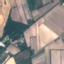

In [6]:
example = dataset["train"][0]
example["image"]

In [7]:
example["label"]

6

In [8]:
labels = dataset["train"].features["label"].names
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}
print(id2label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Load the model

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name, id2label=id2label, label2id=label2id)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Prepare dataset for the model

In [11]:
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ColorJitter, ToTensor, Normalize
import torch

# make sure to use the appropriate image mean, std and interpolation
# of the inference processor
mean = processor.image_mean
std = processor.image_std
interpolation = processor.resample

# for training, we use some image transformations from Torchvision
# feel free to use other libraries like Albumentations or Kornia here
train_transform = Compose([
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=interpolation),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4)),
    ToTensor(),
    Normalize(mean=mean, std=std),
])

In [12]:
def prepare(batch, mode="train"):
  # get images
  images = batch["image"]

  # prepare for the model
  if mode == "train":
    images = [train_transform(image.convert("RGB")) for image in images]
    pixel_values = torch.stack(images)
  elif mode == "test":
    pixel_values = processor(images, return_tensors="pt").pixel_values
  else:
    raise ValueError(f"Mode {mode} not supported")

  inputs = {}
  inputs["pixel_values"] = pixel_values
  inputs["labels"] = torch.tensor(batch["label"])

  return inputs

# set num_proc equal to the number of CPU cores on your machine
# see https://docs.python.org/3/library/multiprocessing.html#multiprocessing.cpu_count
train_dataset = dataset["train"].map(prepare, num_proc=2, batched=True, batch_size=20, fn_kwargs={"mode":"train"})
eval_dataset = dataset["test"].map(prepare, num_proc=2, batched=True, batch_size=20, fn_kwargs={"mode":"test"})

Map (num_proc=2):   0%|          | 0/16200 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/5400 [00:00<?, ? examples/s]

In [13]:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

In [14]:
train_dataset[0]["pixel_values"].shape

torch.Size([3, 224, 224])

In [15]:
train_dataset[0]["labels"]

tensor(6)

## Train the model

In [23]:
from sklearn.metrics import accuracy_score
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_score(y_pred=predictions, y_true=eval_pred.label_ids)
    return {"accuracy": accuracy}

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat-rgb",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.380000,0.303403,0.897593
2,0.124900,0.075539,0.978333


TrainOutput(global_step=3036, training_loss=0.40494401654294826, metrics={'train_runtime': 3722.7717, 'train_samples_per_second': 13.055, 'train_steps_per_second': 0.816, 'total_flos': 3.799158137310413e+18, 'train_loss': 0.40494401654294826, 'epoch': 3.0})

# Load the trained custom model

In [10]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

base_model_name = "facebook/dinov2-base"
custom_model_name = "jucamohedano/dinov2-base-finetuned-eurosat-rgb"
processor = AutoImageProcessor.from_pretrained(base_model_name)
model = AutoModelForImageClassification.from_pretrained(custom_model_name, id2label=id2label, label2id=label2id)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


# Evaluate model



In [70]:
trainer.evaluate(eval_dataset)

{'eval_loss': 0.09141235053539276,
 'eval_accuracy': 0.9712962962962963,
 'eval_runtime': 5069.3332,
 'eval_samples_per_second': 1.065,
 'eval_steps_per_second': 0.133}



# Inference



In [85]:
input = eval_dataset[0]["pixel_values"].unsqueeze(dim=0)
output = model(input)

softmaxed_logits = torch.nn.functional.softmax(output.logits, dim=-1)
predicted_class = torch.argmax(softmaxed_logits)

print("Predicted Class:", id2label[predicted_class.item()])

Predicted Class: Industrial
